In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

In [2]:
def build_generator(img_size, latent_dim):
    z = Input(latent_dim)
    x = tf.keras.layers.Reshape((4, 4, -1))(z)
    
    x = Conv2DTranspose(512, (5, 5), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(512, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(256, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(128, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(img_size[-1], (5,5),strides=(2,2),padding="same", activation = tf.nn.leaky_relu)(x)
    return Model(z, x)

def build_encoder(img_size, latent_dim):
    x = Input(img_size)
    
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    y = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    
    y = Conv2D(1024, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(1024, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    
    y = Flatten()(y)
    y = Dense(latent_dim)(y)
    return Model(x,y)

def build_discriminator(img_size, latent_dim):
    x = Input(img_size)
    z = Input(latent_dim)
    _z = Flatten()(z)
    _z = Dense(img_size[0]*img_size[1]*img_size[2])(_z)
    _z = Reshape(img_size)(_z)

    y = Concatenate()([x,_z])
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(1024, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(1024, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Flatten()(y)
    y = Dense(1)(y)
    return Model([x, z], [y])



In [3]:
def load_dataset(data_dir, img_size = 64, batch_size = 1):
    df = tf.keras.utils.image_dataset_from_directory(directory = data_dir, 
                                                     labels = None, 
                                                     batch_size= None,
                                                     image_size = (img_size, img_size),
                                                     seed = 42)
    
    return df

In [4]:
data_folder = "sample_data/"
img_dim = 64
train_ds = load_dataset(data_folder+"img", img_size = img_dim, batch_size = 1)

Found 2560 files belonging to 1 classes.


2023-03-26 03:35:34.619492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 03:35:34.810580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 03:35:34.814594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 03:35:34.835056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
def apply_norm(x):
    return (x*2)/255.0 - 1

In [6]:
latent_dim = 256
img_size = (img_dim, img_dim, 3)

enc = build_encoder(img_size, latent_dim)
gen = build_generator(img_size, latent_dim)
disc = build_discriminator(img_size, latent_dim)

g_opt = Adam(learning_rate = 1e-4)
e_opt = Adam(learning_rate = 1e-4)
d_opt = Adam(learning_rate = 1e-4)


In [7]:
num = len(train_ds)

train_ds = train_ds.map(apply_norm)
train_ds = tfds.as_numpy(train_ds)

In [8]:
z_train = np.random.normal(scale = 2, size = (num, latent_dim)).astype("float32")

In [9]:
import random

t = list(zip(train_ds, z_train))
random.shuffle(t)
train_ds, z_train = zip(*t)

train_ds = np.array(train_ds)
z_train = np.array(z_train)

In [10]:
epochs = 10
batch_size = 32

In [11]:
X_train = train_ds.reshape(-1, batch_size, img_dim, img_dim, 3)
z_train = z_train.reshape(-1, batch_size, latent_dim)

In [12]:
loss = []
for epoch in tqdm(range(epochs), desc='Total'):
    
    running_loss = [0,0,0]
    num_steps = num//batch_size
    
    perm = np.random.permutation(X_train.shape[0])
    
    X_train = X_train[perm]
    z_train = np.random.normal(scale = 2, size = (num,latent_dim)).astype("float32")
    z_train = z_train.reshape(-1, batch_size, latent_dim)
    
    for steps in range(0, num_steps):
        x_batch = X_train[steps]
        z_batch = z_train[steps]
        
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:      
            fake_img = gen(z_batch)
            fake_z = enc(x_batch)
            
            preds = disc([tf.concat([fake_img, x_batch], axis = 0) , tf.concat([z_batch, fake_z], axis = 0)])
            pred_gen, pred_enc = tf.split(preds, 2, axis = 0)
            
            gen_loss = tf.reduce_mean(tf.nn.softplus(-pred_gen))
            enc_loss = tf.reduce_mean(tf.nn.softplus(pred_enc))
            
            disc_loss = tf.reduce_mean(tf.nn.softplus(pred_gen)) + tf.reduce_mean(tf.nn.softplus(-pred_enc))

        gen_grad = tape.gradient(gen_loss, gen.trainable_variables)        
        disc_grad = tape.gradient(disc_loss, disc.trainable_variables)
        enc_grad = tape.gradient(enc_loss, enc.trainable_variables)

        g_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
        e_opt.apply_gradients(zip(enc_grad,enc.trainable_variables))
        d_opt.apply_gradients(zip(disc_grad,disc.trainable_variables))

        running_loss[0] += disc_loss.numpy()
        running_loss[1] += gen_loss.numpy()
        running_loss[2] += enc_loss.numpy()
        del tape
        
    print('[{}] Desc loss : {:.10f}\t Gen Loss : {:.10f}\t Enc Loss : {:.10f}'.format(epoch,running_loss[0],running_loss[1], running_loss[2] ))
    loss.append(running_loss)

Total:   0%|          | 0/10 [00:00<?, ?it/s]

2023-03-26 03:35:42.636831: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


[0] Desc loss : 222.2328072671	 Gen Loss : 197.0788780915	 Enc Loss : 1403.7956154516
[1] Desc loss : 51.0097200572	 Gen Loss : 70.8681700230	 Enc Loss : 986.4327354431
[2] Desc loss : 16.3435266288	 Gen Loss : 285.6053274870	 Enc Loss : 2111.5173473358
[3] Desc loss : 46.1467623841	 Gen Loss : 159.3426090330	 Enc Loss : 897.0679357052
[4] Desc loss : 41.8989997416	 Gen Loss : 412.5378377413	 Enc Loss : 1927.5998630524
[5] Desc loss : 36.0358508751	 Gen Loss : 271.0834038854	 Enc Loss : 834.2166132927
[6] Desc loss : 23.6911774930	 Gen Loss : 279.9838117361	 Enc Loss : 729.4843578339
[7] Desc loss : 73.9255626202	 Gen Loss : 410.5695020556	 Enc Loss : 429.3588217497
[8] Desc loss : 28.1399257244	 Gen Loss : 211.4816050529	 Enc Loss : 788.6331090927
[9] Desc loss : 59.4748303704	 Gen Loss : 271.4092165306	 Enc Loss : 548.1593351569


1/1 [==============================] - 0s 380ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

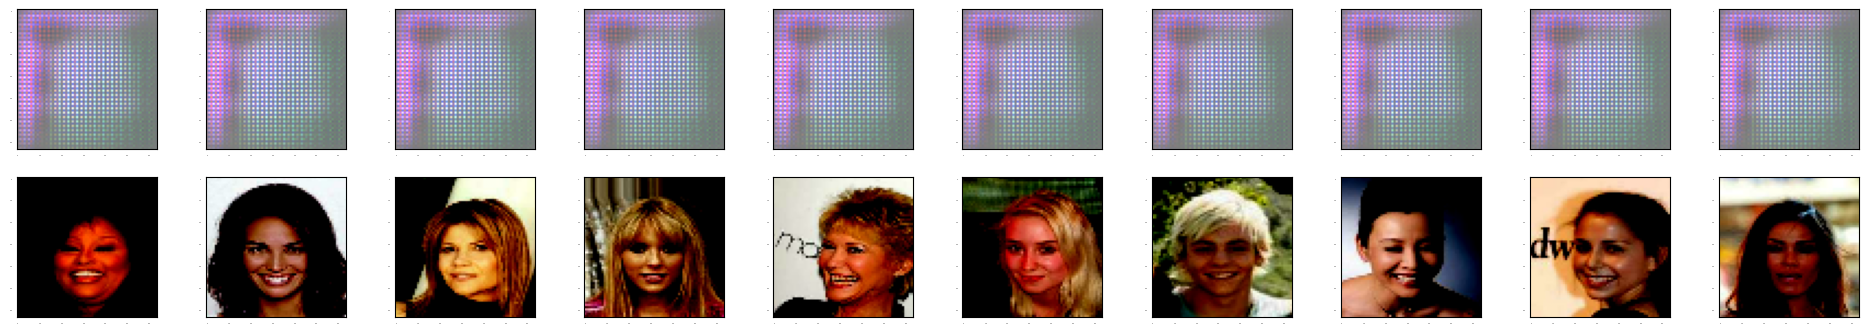

In [13]:
for _ in range(1):
    num_sample = 10
    pred = gen.predict(enc.predict(X_train[0])).reshape(-1, img_dim, img_dim, 3)

    _, axs = plt.subplots(2,num_sample, figsize=(24,4))
    for i in range(num_sample):
        img = np.clip((pred[i]+1)*(255.0/2), 0, 255).astype("uint32")
        axs[0][i].imshow(img)
        axs[0][i].tick_params(length=0, labelsize=0)
        
        axs[1][i].imshow(X_train[0][i])
        axs[1][i].tick_params(length=0, labelsize=0)

1/1 [==============================] - 0s 47ms/step


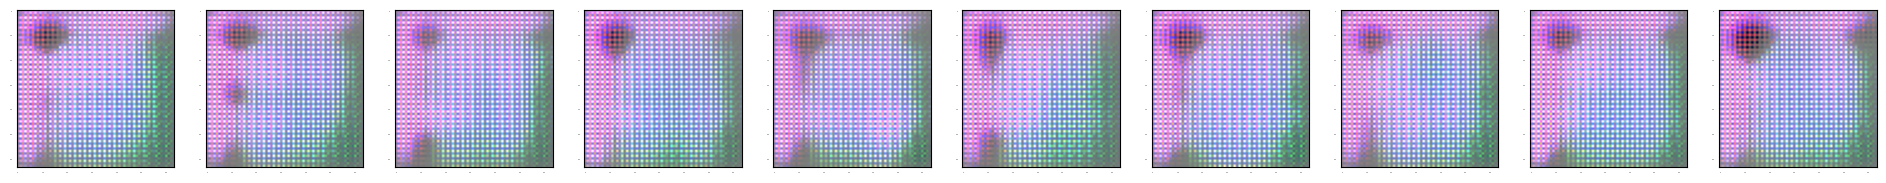

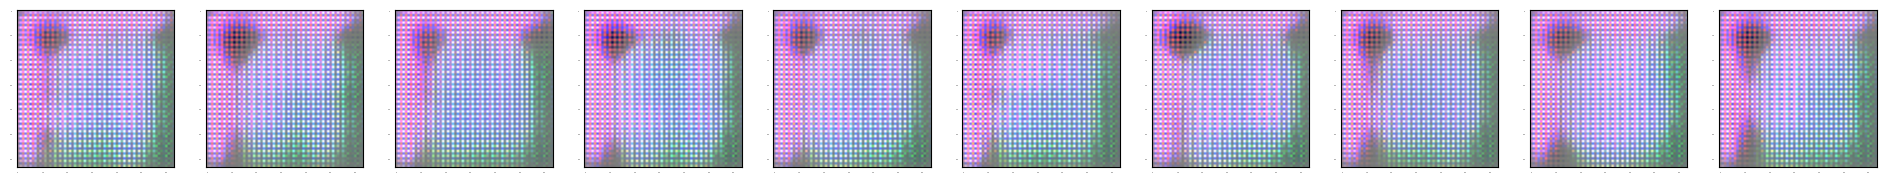

In [14]:
for _ in range(2):
    num_sample = 10
    z_test = np.random.normal(scale = 2, size = (num_sample, latent_dim)).astype("float32")
    pred = gen.predict(z_test[:num_sample]).reshape(-1, img_dim, img_dim, 3)

    _, axs = plt.subplots(1,num_sample, figsize=(24,4))
    for i in range(num_sample):
        img = np.clip((pred[i]+1)*(255.0/2), 0, 255).astype("uint32")
        axs[i].imshow(img)
        axs[i].tick_params(length=0, labelsize=0)